In [1]:
#@ Importing necessary packages and dependencies:
import torch
import torch.nn as nn
import torchvision
import cv2, glob, numpy as np, pandas as pd
from torchvision import transforms, models, datasets
import torch.nn.functional as F
from torch import optim
from glob import glob
from PIL import Image

In [2]:
device='cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
#@ kaggle authentication:
!pip install -q aggle
from google.colab import files
files.upload()

ERROR: Could not find a version that satisfies the requirement aggle (from versions: none)
ERROR: No matching distribution found for aggle


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"prijalkhadka","key":"2071ddf47b17eeaf05c846d655e149dc"}'}

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json


kaggle.json


In [5]:
!kaggle datasets download -d tongpython/cat-and-dog
!unzip cat-and-dog.zip

Streaming output truncated to the last 5000 lines.
  inflating: training_set/training_set/cats/cat.3704.jpg  
  inflating: training_set/training_set/cats/cat.3705.jpg  
  inflating: training_set/training_set/cats/cat.3706.jpg  
  inflating: training_set/training_set/cats/cat.3707.jpg  
  inflating: training_set/training_set/cats/cat.3708.jpg  
  inflating: training_set/training_set/cats/cat.3709.jpg  
  inflating: training_set/training_set/cats/cat.371.jpg  
  inflating: training_set/training_set/cats/cat.3710.jpg  
  inflating: training_set/training_set/cats/cat.3711.jpg  
  inflating: training_set/training_set/cats/cat.3712.jpg  
  inflating: training_set/training_set/cats/cat.3713.jpg  
  inflating: training_set/training_set/cats/cat.3714.jpg  
  inflating: training_set/training_set/cats/cat.3715.jpg  
  inflating: training_set/training_set/cats/cat.3716.jpg  
  inflating: training_set/training_set/cats/cat.3717.jpg  
  inflating: training_set/training_set/cats/cat.3718.jpg  
  infl

In [6]:
#@ Training and test dataset folder:
train_data_dir= '/content/training_set/training_set'
test_data_dir = '/content/test_set/test_set'

In [7]:
#@ Data Fetching and preprocessing:
from torch.utils.data import DataLoader, Dataset
class cats_dogs(Dataset):
  def __init__(self, folder):
    cats=glob(folder + '/cats/*.jpg')
    dogs=glob(folder + '/dogs/*.jpg')
    self.fpaths=cats+dogs
    from random import shuffle, seed; seed(10); shuffle(self.fpaths)
    self.targets=[fpath.split('/')[-1].startswith('dog') \
                for fpath in self.fpaths]

  def __len__(self):
    return len(self.fpaths)

  def __getitem__(self, ix):
    f=self.fpaths[ix]
    target=self.targets[ix]
    im=(cv2.imread(f)[:, :, ::-1])
    im=cv2.resize(im, (224, 224))
    return torch.tensor(im/225).permute(2, 0,1).to(device).float(), \
           torch.tensor([target]).float().to(device)

In [8]:
#@ Inspecting random image:
data=cats_dogs(train_data_dir)
im, label=data[200]

tensor([1.], device='cuda:0')


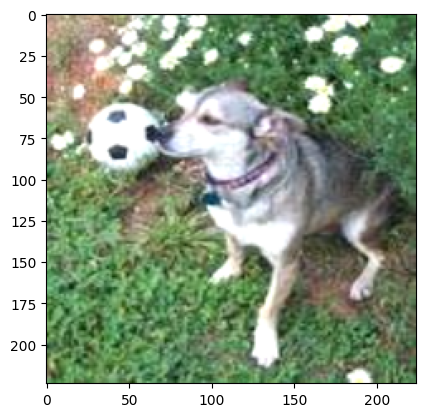

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(im.permute(1, 2,0).cpu())
print(label)

In [14]:
#@ Defining Model:
def ConvLayer(input_channel, output_channel, kernel_size, stride=1):
  return nn.Sequential(
      nn.Conv2d(input_channel, output_channel, kernel_size, stride),
      nn.ReLU(),
      nn.BatchNorm2d(output_channel),
      nn.MaxPool2d(2)
  )

#@ Creating model function which wil perform multiple convolution multiplication
 # by calling ConvLayer function.

def get_model():
  model=nn.Sequential(
          ConvLayer(3, 64, 3),
          ConvLayer(64, 512, 3),
          ConvLayer(512, 512, 3),
          ConvLayer(512, 512, 3),
          ConvLayer(512, 512, 3),
          ConvLayer(512, 512, 3),
          nn.Flatten(),
          nn.Linear(512, 1),
          nn.Sigmoid()
    ).to(device)


  loss_func=nn.BCELoss()
  optimizer=torch.optim.Adam(model.parameters(), lr=1e-3)
  return model, loss_func, optimizer

In [22]:
!pip install torch_summary
from torchsummary import summary
model, loss_func, optimizer= get_model()
summary(model, torch.zeros(1, 3, 224, 224));


Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 64, 111, 111]        --
|    └─Conv2d: 2-1                       [-1, 64, 222, 222]        1,792
|    └─ReLU: 2-2                         [-1, 64, 222, 222]        --
|    └─BatchNorm2d: 2-3                  [-1, 64, 222, 222]        128
|    └─MaxPool2d: 2-4                    [-1, 64, 111, 111]        --
├─Sequential: 1-2                        [-1, 512, 54, 54]         --
|    └─Conv2d: 2-5                       [-1, 512, 109, 109]       295,424
|    └─ReLU: 2-6                         [-1, 512, 109, 109]       --
|    └─BatchNorm2d: 2-7                  [-1, 512, 109, 109]       1,024
|    └─MaxPool2d: 2-8                    [-1, 512, 54, 54]         --
├─Sequential: 1-3                        [-1, 512, 26, 26]         --
|    └─Conv2d: 2-9                       [-1, 512, 52, 52]         2,359,808
|    └─ReLU: 2-10                        [-1, 512, 52, 52]        

In [24]:
#@ For dataloader of batch size 32
def get_data():
  train=cats_dogs(train_data_dir)
  train_dl=DataLoader(train, batch_size=32, shuffle=True, drop_last=True)
  val=cats_dogs(test_data_dir)
  val_dl=DataLoader(val, batch_size=32, shuffle=True, drop_last=True)
  return train_dl, val_dl


In [25]:
#@ For training model on a batch
def train_batch(x, y, model, opt, loss_func):
  model.train()
  prediction=model(x)
  batch_loss=loss_func(prediction, y)
  batch_loss.backward()
  optimizer.step()
  optimizer.zero_grad()
  return batch_loss.item()

In [26]:
#@ for calculating accuracy and validation:
@torch.no_grad()
def accuracy(x, y, model):
  prediction=model(x)
  is_correct=(prediction > 0.5)== y
  return is_correct.cpu().numpy().tolist()

@torch.no_grad()
def val_loss(x, y, model):
  prediction=model(x)
  val_loss=loss_func(prediction, y)
  return val_loss.item()


In [29]:
# training model over increasing epochs:
train_dl, val_dl=get_data()
model, loss_func, optimizer=get_model()

train_losses, train_accuracies=[], []
val_losses, val_accuracies=[], []

for epoch in range(5):
    train_epoch_losses, train_epoch_accuracies=[], []
    val_epoch_accuracies=[]

     # For epoch training loss:
    for ix, batch in enumerate(iter(train_dl)):
      x, y=batch
      batch_loss=train_batch(x, y, model, optimizer, loss_func)
      train_epoch_losses.append(batch_loss)
    train_epoch_loss=np.array( train_epoch_losses).mean()

     # for epoch training accuracy:
    for ix, batch in enumerate(iter(train_dl)):
      x, y=batch
      is_correct=accuracy(x, y, model)
      train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy=np.mean( train_epoch_accuracies)

    #for epoch val accuracy:
    for ix, batch in enumerate(iter(val_dl)):
      x, y=batch
      val_is_correct=accuracy(x, y, model)
      val_epoch_accuracies.extend(val_is_correct)
    val_epoch_accuracy=np.mean(val_epoch_accuracies)


  # appending in main list:
    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_accuracies.append(val_epoch_accuracy)

<ipython-input-30-157126b48dec>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) \


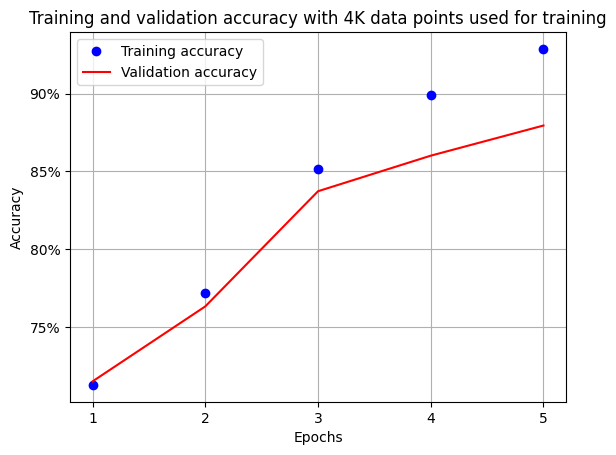

In [30]:
#@ Visualization:
epochs = np.arange(5)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
plt.plot(epochs, train_accuracies, 'bo',
         label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r',
 label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation accuracy \
with 4K data points used for training')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) \
 for x in plt.gca().get_yticks()])
plt.legend()
plt.grid('off')
plt.show()

In [31]:
#@ Saving:
save_path='mymodel.pth'
torch.save(model.state_dict(), save_path)
!du -hsc {save_path}

38M	mymodel.pth
38M	total


In [32]:
#@ Loading:
load_path='mymodel.pth'
model.load_state_dict(torch.load(load_path))

<All keys matched successfully>